Use the dataset __USPS__, available either on torchvision.datasets or on Canvas. It contains images of hand-written digits of size 16 × 16 pixels, with a training set of
7291 images and a test set of 2007 images. Implement the label propagation and dynamic label propagation methods. Construct the affinity matrix using a $W_{ij} =
exp{(−∥x_{i}−x_{j}∥^{2}/\sigma^{2})}$, where σ is a tuning parameter. Use 100 random training observations as labeled data and the test data as unlabeled. Run the following methods 10
times with different 100 random labeled observations each time, and report the average misclassification error on the test set.

## Import necessary libraries

In [438]:
import math
import random
import numpy as np
import pandas as pd

import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import urllib
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Set plotting options

In [151]:
plt.figure(figsize=(16,16))

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

## Set data paths

In [341]:
test_data = r'C:\...\knntrain\usps.t\usps.t'
training_data = r'C:\...\knntrain\usps\usps'

## Extract image

In [353]:
def read_image(pixels):
    image_array = pixels.split() 
    label = int(image_array[0]) - 1
    image_array.pop(0)
    for i in range(len(image_array)):   
        image_array[i] = abs(float(image_array[i].split(':')[1]))
    return {
        'label': label,
        'image': np.array(np.array_split(image_array, 16))
    }    

## Load image file

In [354]:
def load_images(path):
    f = open(path, 'r')
    lines = f.readlines()
    f.close()
    images = []
    labels = []
    for i in range(len(lines)): 
        img = read_image(lines[i])
        images.append(img['image'])  
        labels.append(img['label'])
    return {
        'images': images,
        'labels': labels
    }

## Load training images

In [355]:
training_images = load_images(training_data)

## Load test images

In [356]:
test_images = load_images(test_data)

## Show sample training image

Image label: 3


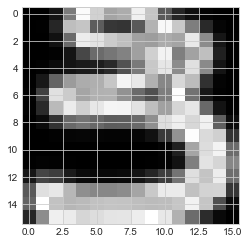

In [357]:
training_sample_image = training_images['images'][255]
training_sample_label = training_images['labels'][255]
print(f"Image label: {training_sample_label}")
plt.imshow(training_sample_image)
plt.show()

## Show sample test image

Image label: 6


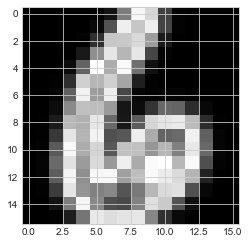

In [358]:
test_sample_image = test_images['images'][150]
test_sample_label = test_images['labels'][150]
print(f"Image label: {test_sample_label}")
plt.imshow(test_sample_image)
plt.show()

## Create models

- $k$-NN classifier. Use the k that gives the smallest test error.
- Label propagation. Find the σ that gives the smallest test error.
- Dynamic label propagation. Find the $\sigma$ and $k$ that give the smallest test error.

In [486]:
def knn_classifier(x_train, y_train, k): 
    for i in range(len(x_train)):
        tmp = np.array(x_train[i])
        x_train[i] = tmp.flatten()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    return knn

def label_propagation(x_train, masked_labels, σ, k=7): 
    for i in range(len(x_train)):
        tmp = np.array(x_train[i])
        x_train[i] = np.array(tmp.flatten())  
    g = 1/(σ*σ)
    lp = LabelPropagation(gamma=g,n_neighbors=k)
    lp.fit(np.array(x_train), masked_labels)
    return lp

def dynamic_label_propagation(x_train, y_train, σ, k): 
    return(label_propagation(x_train, y_train, σ, k))

## Model test helper

In [441]:
def run_model(model, x_test):
    for i in range(len(x_test)):
        tmp = np.array(x_test[i])
        x_test[i] = tmp.flatten()
    return model.predict(x_test)

## Generate random subset of training data

In [442]:
def generate_random(img_arr, label_arr, size):
    rand_list = random.sample(range(0, len(img_arr) - 1), size)
    imgs = []
    labels = []
    for i in range(len(rand_list)):
        imgs.append(img_arr[rand_list[i]])
        labels.append(label_arr[rand_list[i]]) 
    return [imgs, labels]

## Mask data

In [495]:
def mask_data(data, percentage):
    labels = data.copy()    
    rand_list = random.sample(range(0, len(data) - 1), int(percentage * len(data) - 1))
    for i in range(len(rand_list)):
        labels[i] = -1    
    return labels

a) $k$-NN classifier. Use the k that gives the smallest test error.

In [454]:
k = 1
accuracy_list = []
for i in range(10):
    x_train, y_train = generate_random(training_images['images'],training_images['labels'], 100)
    x_test_images, y_test_labels = [test_images['images'], test_images['labels']]
    model = knn_classifier(x_train, y_train, k)
    y_classified = run_model(model, x_test_images)
    accuracy_list.append(metrics.accuracy_score(y_test_labels, y_classified))
accuracy = sum(accuracy_list) / 10
print(f'k = {k} gives the smallest test error, accuracy = {accuracy}')

k = 1 gives the smallest test error, accuracy = 0.7516691579471849


b) Label propagation. Find the σ that gives the smallest test error.

In [522]:
σ = 1
accuracy_list = []   

for i in range(10):
    x_train, y_train = generate_random(training_images['images'],training_images['labels'], 100)
    x_test_images, y_test_labels = [test_images['images'], test_images['labels']]    
    # mask 10% of labels
    masked_labels = mask_data(y_train, 0.1)
    model = label_propagation(x_train, masked_labels, σ)
    y_classified = run_model(model, x_test_images)
    accuracy_list.append(metrics.accuracy_score(y_test_labels, y_classified))
accuracy = sum(accuracy_list) / 10
print(f'σ = {σ} gives the smallest test error, accuracy = {accuracy}')

σ = 1 gives the smallest test error, accuracy = 0.7492775286497259


c) Dynamic label propagation. Find the σ and k that give the smallest test error.

In [544]:
σ = 1
k = 11
accuracy_list = []
for i in range(10):
    x_train, y_train = generate_random(training_images['images'],training_images['labels'], 100)
    x_test_images, y_test_labels = [test_images['images'], test_images['labels']]    
    # mask 20% of labels
    masked_labels = mask_data(y_train, 0.2)
    model = dynamic_label_propagation(x_train, masked_labels, σ, k)
    y_classified = run_model(model, x_test_images)
    accuracy_list.append(metrics.accuracy_score(y_test_labels, y_classified))
accuracy = sum(accuracy_list) / 10
print(f'k = {k}, σ = {σ} give the smallest test error, accuracy = {accuracy}')

k = 11, σ = 1 give the smallest test error, accuracy = 0.7307424015944195
